In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import numpy as np

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [26]:
model_names = [

    # "nrbmvo_lo_nobb_95", "nrbmvo_lo_cbb_95", "nrbmvo_lo_sb_95",
    "nrbmvo_ls_nobb_95", "nrbmvo_ls_cbb_95", "nrbmvo_ls_sb_95",

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

vol_target = 0.2

In [25]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

ValueError: No objects to concatenate

## 1) Summary Statistics of the Portfolios

In [22]:
all_stats = {}
for model in model_names:

    portfolio_returns = all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target =  torch.tensor((portfolio_returns * (vol_target / portfolio_vol)).dropna().to_numpy())
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns_target)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
nrbmvo_lo_nobb_95,26.442871,21.718690,1.217517,1.485595,-6.785189,-29.377089,0.533713
nrbmvo_lo_cbb_95,30.867376,21.764117,1.418269,1.693675,-7.209456,-36.420458,0.536110
nrbmvo_lo_sb_95,24.277296,20.988790,1.156679,1.383463,-10.612078,-38.253548,0.530716


## 2) Cummulative Returns of the Portfolios

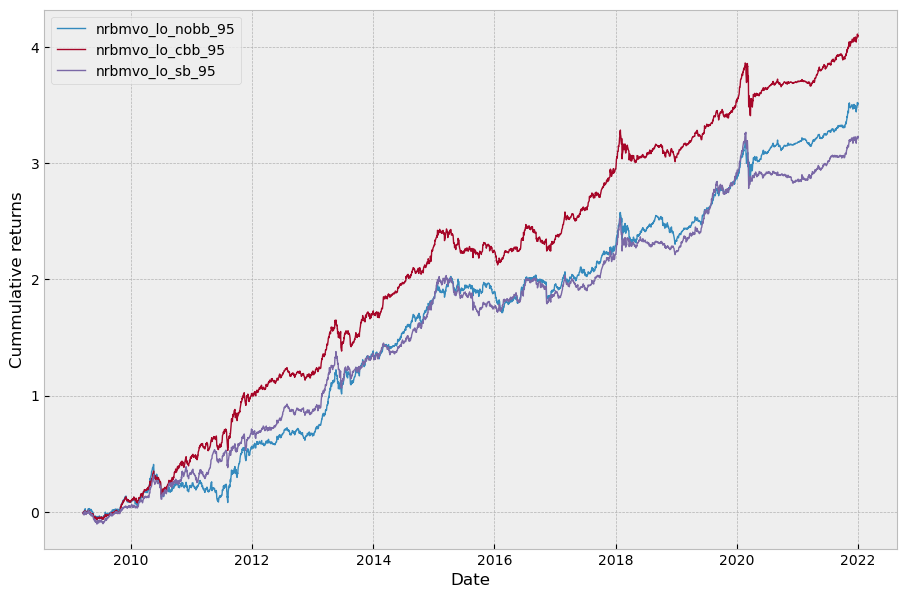

In [23]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    cum_pnl_df = portfolio_returns_target.loc["2007-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [13]:
check_name = model_names[0]
all_summary_df.loc[(all_summary_df["model"] == check_name), ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,80682.000000,8.068200e+04,80682.000000
mean,0.000271,4.761905e-02,0.000013
std,0.021404,4.102299e-14,0.001019
min,-0.350589,4.761905e-02,-0.016695
25%,-0.004723,4.761905e-02,-0.000225
50%,0.000193,4.761905e-02,0.000009
75%,0.005663,4.761905e-02,0.000270
max,0.768245,4.761905e-02,0.036583


In [14]:
all_summary_df.loc[all_summary_df["returns"] >= 100]

,date,ticker,returns,weights,pnl,model
